In [1]:
# from oauth2client.client import GoogleCredentials
from google.colab import files, drive, auth
import os, os.path

drive.mount("/content/gdrive", force_remount=False)

PATH = "/content/gdrive/My Drive/PROJET TAV/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
% matplotlib inline

import time
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

import pandas as pd
import numpy as np

Using TensorFlow backend.


In [0]:
 path_ = os.path.join(PATH,"data")
 glob_ = glob.iglob(f"{path_}/*")
 sequences = [os.path.basename(seq) for seq in glob_]
 folders = list(map(lambda sequence: os.path.join(path_,sequence),sequences))               

def NumberImageBySequence():
    stats=[]
    for folder in folders :
            images = [os.path.basename(img) for img in glob.iglob(f"{folder}/*.jpg")]
            image_count = len(images)
            stats.append({ "NbrImages": image_count,
                           "CodSeq": "S"+str(int(os.path.basename(folder).split("_")[1])),
                           "Sequence": os.path.basename(folder)})
    df = pd.DataFrame(stats)
    return df

In [4]:
df = NumberImageBySequence()
df

,CodSeq,NbrImages,Sequence
0,S1,14,SEQ_001_VIDEO
1,S3,3,SEQ_003_VIDEO
2,S4,9,SEQ_004_VIDEO
3,S5,20,SEQ_005_VIDEO


In [0]:

def loadImages(sequences):
    # Define empty arrays where we will store our images and labels
    images_ = []
    labels = []
    PATH = "/content/gdrive/My Drive/PROJET TAV/"
    for sequence in sequences: 
        path_ = os.path.join(PATH,"data",sequence)
        images = glob.iglob(f"{path_}/*.jpg")
        for image in images:                 
            # build file path
            image_path = os.path.join(path_, image)
        
            # Read the image
            img = cv2.imread(image_path)

            # Resize it to 224 x 224 because is the best size of VGG19
            img = cv2.resize(img, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            codSeq = "S"+str(int(sequence.split("_")[1]))
            images_.append(img)
            labels.append(codSeq)

    return images_, labels

In [0]:
a,b = loadImages(df["Sequence"])
#a[2]

In [51]:
df["Sequence"]

0    SEQ_001_VIDEO
1    SEQ_003_VIDEO
2    SEQ_004_VIDEO
3    SEQ_005_VIDEO
Name: Sequence, dtype: object

In [0]:
# Display Photos
sequences = df["Sequence"]
images, labels = loadImages(sequences)

In [0]:
def showRandomImages(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):
      
        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for codSeq {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for codSeq S3


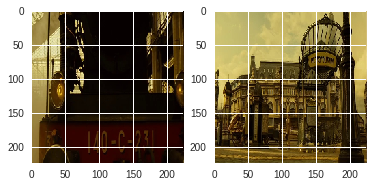

2 random images for codSeq S4


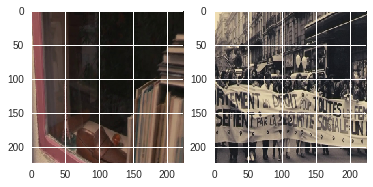

2 random images for codSeq S5


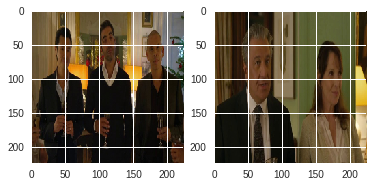

2 random images for codSeq S1


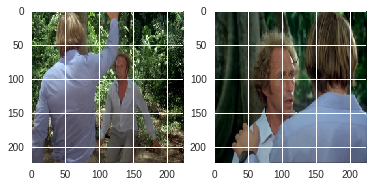

In [8]:
showRandomImages(images, labels, number_of_images_to_show=2)

In [0]:
#Normaliser les images avant d'applique le VGG19

def normaliseImages(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [10]:
images, labels = normaliseImages(images, labels)
labels

array(['S1', 'S1', 'S1', 'S1', 'S1', 'S1', 'S1', 'S1', 'S1', 'S1', 'S1',
       'S1', 'S1', 'S1', 'S3', 'S3', 'S3', 'S4', 'S4', 'S4', 'S4', 'S4',
       'S4', 'S4', 'S4', 'S4', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5',
       'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5',
       'S5', 'S5'], dtype='<U2')

In [0]:
#malanger les images et diviser en train_test

def shuffleData(images, labels):

    # Just to shuffle our data so not to have test part. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0, random_state=8)
    
    return X_train, y_train

In [0]:
X_train, y_train = shuffleData(images, labels)
#X_train[0][2]

In [0]:
# les modeles CNN pre-trainés
# Load the models with ImageNet weights // On enlève les 1ere couches denses

model_vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

model_vgg19 = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

model_resnet50 = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [0]:
#model_vgg16.summary()

In [0]:
#appliquer un flatten sur la dim 3D du model cnn pour pourvoir les appliquer sur les algo de clustering

def CNNtransform(model, raw_images):

    # Pass our training data through the network
    predicted = model.predict(raw_images)

    # Flatten the array
    flat = predicted.reshape(raw_images.shape[0], -1)
    
    return flat

In [15]:
Result_vgg16 = CNNtransform(model_vgg16, X_train)
print("VGG16 flattened output has {} features".format(Result_vgg16.shape[1]))

Result_vgg19 = CNNtransform(model_vgg19, X_train)
print("VGG19 flattened output has {} features".format(Result_vgg19.shape[1]))

Result_resnet50 = CNNtransform(model_resnet50, X_train)
print("ResNet50 flattened output has {} features".format(Result_resnet50.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 2048 features


on voit que chaque image à 25088 (pour les 2 1er models) features ce qui est considerablement reduit vue qu'on avait 224x224x3=150528 features/pixels au depart
Cette reduction va nous aider pour nos algo de clustering.

KMeans peut travailler avec cette dim reducte mais le GMM n'ont et l'ordi risque de manquer de RAM --> Une PCA

In [0]:
# PCA
# creer une instance pca, l'entrainer sur les données et retourné l'intance
def createFitPCA(data, n_components=None): 
    
    p = PCA(n_components=n_components, random_state=8)
    p.fit(data)
    
    return p

In [0]:
# Creer une intance PCA pour chaque modele cnn
pca_vgg16 = createFitPCA(Result_vgg16)
pca_vgg19 = createFitPCA(Result_vgg19)
pca_resnet50 = createFitPCA(Result_resnet50)

In [0]:
# plot du nbre la variance cumulative de chaque composantes,
def pcaCumSumPlot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('nb de composantes')
    plt.ylabel('var expliquée cumulative')
    plt.show()

In [0]:
#pca_vgg16.explained_variance_ratio_

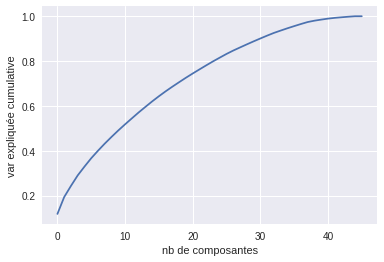

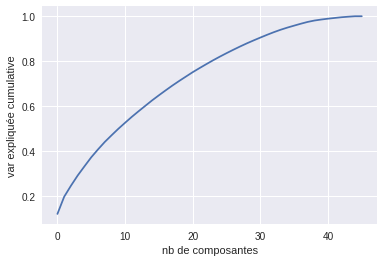

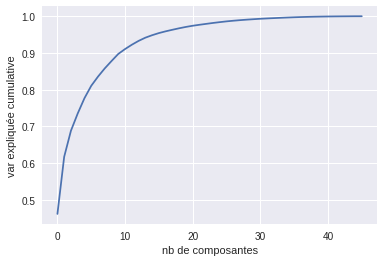

In [19]:
pcaCumSumPlot(pca_vgg16)
pcaCumSumPlot(pca_vgg19)
pcaCumSumPlot(pca_resnet50)

In [0]:
# PCA transformations su les resultat de cnn
ResultPCAvgg16 = pca_vgg16.transform(Result_vgg16)
ResultPCAvgg19 = pca_vgg19.transform(Result_vgg19)
ResultPCAresnet50 = pca_resnet50.transform(Result_resnet50)

In [21]:
len(labels)

46

In [0]:
#CLUSTERING :: 1) Kmeans

def createTrainKmeans(data, number_of_clusters=len(sequences)):   #number_of_clusters a faire varier dans tout le corpus
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=8) # n_jobs = -1 to use all available CPU cores

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [0]:
#CLUSTERING :: 2)GMM
def createTrainGMM(data, number_of_clusters=len(sequences)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=8)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [24]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = createTrainKmeans(ResultPCAvgg16)

print("\nVGG19")
K_vgg19_pca = createTrainKmeans(ResultPCAvgg19)

print("\nResNet50")
K_resnet50_pca = createTrainKmeans(ResultPCAresnet50)

print("-------------------------------------------------","\n")

# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = createTrainGMM(ResultPCAvgg16)

print("\nVGG19")
G_vgg19_pca = createTrainGMM(ResultPCAvgg19)

print("\nResNet50")
G_resnet50_pca = createTrainGMM(ResultPCAresnet50)

print("----------------- Sans le PCA ---------------------------","\n")

# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = createTrainKmeans(Result_vgg16)

print("\nVGG19:")
K_vgg19 = createTrainKmeans(Result_vgg19)

print("\nResNet50:")
K_resnet50 = createTrainKmeans(Result_resnet50)


### Same for Gaussian Model without PCA return MemoryError
#print("GMM : \n")

#print("VGG16")
#G_vgg16 = createTrainGMM(Result_vgg16)

#print("\nVGG19")
#G_vgg19 = createTrainGMM(Result_vgg19)

#print("\nResNet50")
#G_resnet50 = createTrainGMM(Result_resnet50)

KMeans (PCA): 

VGG16
Training took 0.358900785446167 seconds

VGG19
Training took 0.38425707817077637 seconds

ResNet50
Training took 0.3856196403503418 seconds
------------------------------------------------- 

GMM (PCA): 

VGG16
Training took 0.014586210250854492 seconds

VGG19
Training took 0.01077127456665039 seconds

ResNet50
Training took 0.01506185531616211 seconds
----------------- Sans le PCA --------------------------- 

KMeans: 

VGG16:
Training took 1.0549895763397217 seconds

VGG19:
Training took 0.8958001136779785 seconds

ResNet50:
Training took 0.3846299648284912 seconds


In [0]:
# Now we get the custer model predictions


# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(Result_vgg16)
k_vgg19_pred = K_vgg19.predict(Result_vgg19)
k_resnet50_pred = K_resnet50.predict(Result_resnet50)

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(ResultPCAvgg16)
k_vgg19_pred_pca = K_vgg19_pca.predict(ResultPCAvgg19)
k_resnet50_pred_pca = K_resnet50_pca.predict(ResultPCAresnet50)

# Gaussian Mixture with PCA outputs
g_vgg16_pred_pca = G_vgg16_pca.predict(ResultPCAvgg16)
g_vgg19_pred_pca = G_vgg19_pca.predict(ResultPCAvgg19)
g_resnet50_pred_pca = G_resnet50_pca.predict(ResultPCAresnet50)

In [26]:
K_vgg19_pca.labels_

array([2, 1, 3, 2, 2, 1, 1, 3, 1, 2, 2, 2, 3, 1, 2, 2, 1, 1, 0, 1, 2, 2,
       2, 3, 2, 2, 0, 3, 2, 2, 2, 3, 2, 2, 3, 3, 1, 3, 0, 2, 3, 2, 3, 2,
       0, 3], dtype=int32)

In [27]:
k_vgg19_pred_pca

array([2, 1, 3, 2, 2, 1, 1, 3, 1, 2, 2, 2, 3, 1, 2, 2, 1, 1, 0, 1, 2, 2,
       2, 3, 2, 2, 0, 3, 2, 2, 2, 3, 2, 2, 3, 3, 1, 3, 0, 2, 3, 2, 3, 2,
       0, 3], dtype=int32)

In [28]:
ResultPCAvgg16.shape

(46, 46)

We now need to count how many of each label are in each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [0]:
def clusterLabelCount(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [0]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = clusterLabelCount(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = clusterLabelCount(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = clusterLabelCount(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = clusterLabelCount(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = clusterLabelCount(k_resnet50_pred, y_train)
resnet_cluster_count_pca = clusterLabelCount(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = clusterLabelCount(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = clusterLabelCount(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = clusterLabelCount(g_resnet50_pred_pca, y_train)

In [31]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2,3
S1,4,0,5,5
S3,3,0,0,0
S4,9,0,0,0
S5,11,9,0,0


In [32]:
K_vgg16_pca.labels_

array([0, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 3, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 3, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 2, 2, 1, 3, 0, 0, 2, 0, 0, 0,
       0, 3], dtype=int32)

In [33]:
y_train

array(['S5', 'S5', 'S1', 'S5', 'S4', 'S5', 'S5', 'S1', 'S5', 'S4', 'S3',
       'S1', 'S1', 'S5', 'S5', 'S5', 'S5', 'S5', 'S4', 'S5', 'S1', 'S4',
       'S5', 'S1', 'S5', 'S5', 'S4', 'S1', 'S3', 'S4', 'S5', 'S1', 'S5',
       'S3', 'S1', 'S1', 'S5', 'S1', 'S4', 'S4', 'S1', 'S5', 'S1', 'S5',
       'S4', 'S1'], dtype='<U2')

In [34]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2,3
S1,4,0,5,5
S3,3,0,0,0
S4,9,0,0,0
S5,11,9,0,0


In [0]:
vgg16_cluster_code_pca = ["S5", "S5", "S1", "S1"]

In [35]:
print("KMeans VGG16 : ")
vgg16_cluster_count

KMeans VGG16 : 


,0,1,2,3
S1,4,0,5,5
S3,3,0,0,0
S4,9,0,0,0
S5,11,9,0,0


In [36]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2,3
S1,0,0,2,12
S3,0,0,3,0
S4,4,0,5,0
S5,0,9,11,0


In [0]:
vgg19_cluster_code_pca = ["S4","S5","S5","S1"]

In [37]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1,2,3
S1,0,0,2,12
S3,0,0,3,0
S4,4,0,5,0
S5,0,9,11,0


In [46]:
g_vgg19_cluster_count_pca

,0,1,2,3
S1,2,0,3,9
S3,3,0,0,0
S4,9,0,0,0
S5,11,9,0,0


In [0]:
#assignation manuelle de labels aux clusters
vgg16_cluster_code_pca = ["S5", "S5", "S1", "S1"]
vgg16_cluster_code = ["S5", "S5", "S1", "S1"]

vgg19_cluster_code_pca = ["S4","S5","S5","S1"]
vgg19_cluster_code = ["S4","S5","S5","S1"]

g_vgg19_cluster_code_pca = ["S5", "S5", "S1", "S1"]

In [0]:
#remplace les cluster predicts par leur labels
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in g_vgg19_pred_pca]

In [49]:
np.array(vgg16_pred_codes)

array(['S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S1', 'S5', 'S5', 'S5',
       'S5', 'S1', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5',
       'S5', 'S1', 'S5', 'S5', 'S5', 'S1', 'S5', 'S5', 'S5', 'S1', 'S5',
       'S5', 'S1', 'S1', 'S5', 'S1', 'S5', 'S5', 'S1', 'S5', 'S5', 'S5',
       'S5', 'S1'], dtype='<U2')

In [41]:
y_train

array(['S5', 'S5', 'S1', 'S5', 'S4', 'S5', 'S5', 'S1', 'S5', 'S4', 'S3',
       'S1', 'S1', 'S5', 'S5', 'S5', 'S5', 'S5', 'S4', 'S5', 'S1', 'S4',
       'S5', 'S1', 'S5', 'S5', 'S4', 'S1', 'S3', 'S4', 'S5', 'S1', 'S5',
       'S3', 'S1', 'S1', 'S5', 'S1', 'S4', 'S4', 'S1', 'S5', 'S1', 'S5',
       'S4', 'S1'], dtype='<U2')

Avec nos deux tableau, predict et train on peut calculer le score de prediction

In [50]:
def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}%   |   Accuracy: {0:0.8f}%".format(f1*100,acc*100)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 38.69047619%   |   Accuracy: 38.69047619%
KMeans VGG16 (PCA) 
	F1 Score: 38.69047619%   |   Accuracy: 38.69047619%

KMeans VGG19:  
	F1 Score: 58.46153846%   |   Accuracy: 58.46153846%
KMeans VGG19 (PCA):  
	F1 Score: 58.46153846%   |   Accuracy: 58.46153846%
GMM VGG19 (PCA) 
	F1 Score: 41.59544160%   |   Accuracy: 41.59544160%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
def all_covnet_transform(data):
    vgg16 = CNNtransform(model_vgg16, data)
    vgg19 = CNNtransform(model_vgg19, data)
    resnet50 = CNNtransform(model_resnet50, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = loadImages(codes)   #codes == sequences name
    print(len(images), len(labels))
    showRandomImages(images, labels)
    
    # Normalise images
    images, labels = normaliseImages(images, labels)
    
    # Split data
    data, labels = shuffleData(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = createFitPCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = createFitPCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = createFitPCA(resnet50_output).transform(resnet50_output)
    
        # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = createTrainKmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred =  createTrainKmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = createTrainKmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = createTrainKmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = createTrainKmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = createTrainKmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    G_vgg16_pred_pca = createTrainGMM(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    G_vgg19_pred_pca = createTrainGMM(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    G_resnet50_pred_pca = createTrainGMM(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = clusterLabelCount(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = clusterLabelCount(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = clusterLabelCount(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = clusterLabelCount(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = clusterLabelCount(K_resnet50_pred, labels)
    resnet_cluster_count_pca = clusterLabelCount(K_resnet50_pred_pca, labels)

    # GMM
    g_vgg16_cluster_count_pca = clusterLabelCount(G_vgg16_pred_pca, labels)
    g_vgg19_cluster_count_pca = clusterLabelCount(G_vgg19_pred_pca, labels)
    g_resnet50_cluster_count_pca = clusterLabelCount(G_resnet50_pred_pca, labels)
    
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nGMM VGG16: ")
    print(g_vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("GMM VGG19 (PCA): ")
    print(g_vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    print("GMM Resnet50 (PCA): ")
    print(g_resnet50_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, G_vgg19_pred_pca, images, labels
    

14 14
2 random images for codSeq S1


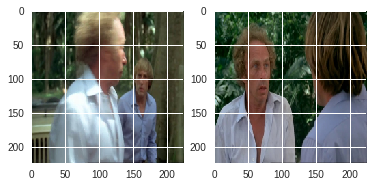

Training took 0.6906983852386475 seconds
Training took 0.569434642791748 seconds
Training took 0.5543971061706543 seconds
Training took 0.5400092601776123 seconds
Training took 0.46840906143188477 seconds
Training took 0.48528456687927246 seconds
Training took 0.004060506820678711 seconds
Training took 0.0031273365020751953 seconds
Training took 0.003167867660522461 seconds
KMeans VGG16: 
     0
S1  14

KMeans VGG16 (PCA): 
     0
S1  14

GMM VGG16: 
     0
S1  14

KMeans VGG19: 
     0
S1  14

KMeans VGG19 (PCA): 
     0
S1  14
GMM VGG19 (PCA): 
     0
S1  14
KMeans Resnet50: 
     0
S1  14
Kmeans Resnet50 (PCA): 
     0
S1  14
GMM Resnet50 (PCA): 
     0
S1  14


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([[[[0.21960784, 0.19215687, 0.15686275],
          [0.23137255, 0.20784314, 0.16470589],
          [0.23529412, 0.20784314, 0.16862746],
          ...,
          [0.23921569, 0.3882353 , 0.29803923],
          [0.20392157, 0.34117648, 0.23137255],
          [0.05490196, 0.16470589, 0.07058824]],
 
         [[0.28627452, 0.2627451 , 0.16862746],
          [0.3019608 , 0.27450982, 0.1882353 ],
          [0.3019608 , 0.2784314 , 0.1882353 ],
          ...,
          [0.34509805, 0.48235294, 0.39607844],
          [0.34901962, 0.48235294, 0.38431373],
          [0.16470589, 0.2627451 , 0.1764706 ]],
 
         [[0.29803923, 0.27058825, 0.19607843],
          [0.29411766, 0.266

In [72]:
seq = ["SEQ_001_VIDEO"]
image_load_to_cluster_count(seq)

In [62]:
df["Sequence"]

0    SEQ_001_VIDEO
1    SEQ_003_VIDEO
2    SEQ_004_VIDEO
3    SEQ_005_VIDEO
Name: Sequence, dtype: object